# Model-Based Feature Importance
    Global Interpretability from Trained Models
## Objective

This notebook introduces model-based (global) feature importance, focusing on:

- What model-based importance actually measures

- Differences across model families

- Strengths and limitations

- Best practices for trustworthy interpretation

It answers:

    Which features does the model rely on most overall — and can we trust that ranking?

## Why Global Interpretability Matters

Global interpretability is required for:

- Model governance

- Regulatory documentation (e.g., credit risk)

- Feature auditing

- Bias and leakage detection

- Stakeholder communication

Without it:

- Models become unexplainable black boxes

- Risk decisions are indefensible

## Types of Model-Based Feature Importance

| Model Family      | Importance Mechanism            |
| ----------------- | ------------------------------- |
| Linear models     | Coefficients                    |
| Tree-based models | Split gain / impurity reduction |
| Ensembles         | Aggregated split statistics     |


    📌 Importance ≠ causality

## Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [46]:
 # Dataset

DATA_PATH = '''D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv'''

df = pd.read_csv(DATA_PATH)


X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)

# Linear Model Feature Importance (Coefficients)
## Train Regularized Logistic Regression

In [21]:
logit_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        penalty="l1",
        solver="liblinear",
        class_weight="balanced"
    ))
])

logit_pipeline.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty='l1', solver='liblinear'))])

## Extract and Interpret Coefficients

In [24]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": logit_pipeline.named_steps["model"].coef_[0]
})

coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

coef_df.sort_values("abs_coefficient", ascending=False)


,feature,coefficient,abs_coefficient
2,credit_utilization,1.601696,1.601696
8,credit_score,-1.397074,1.397074
3,debt_to_income,1.294922,1.294922
1,annual_income,-0.900986,0.900986
7,employment_years,-0.666391,0.666391
6,num_past_defaults,0.506047,0.506047
4,loan_amount,0.389933,0.389933
0,age,0.032175,0.032175
5,loan_term_months,-0.001657,0.001657


📌 Interpretation:

- Sign → direction of impact

- Magnitude → strength of influence

- Zero → feature removed by regularization

##  Visualize Coefficients

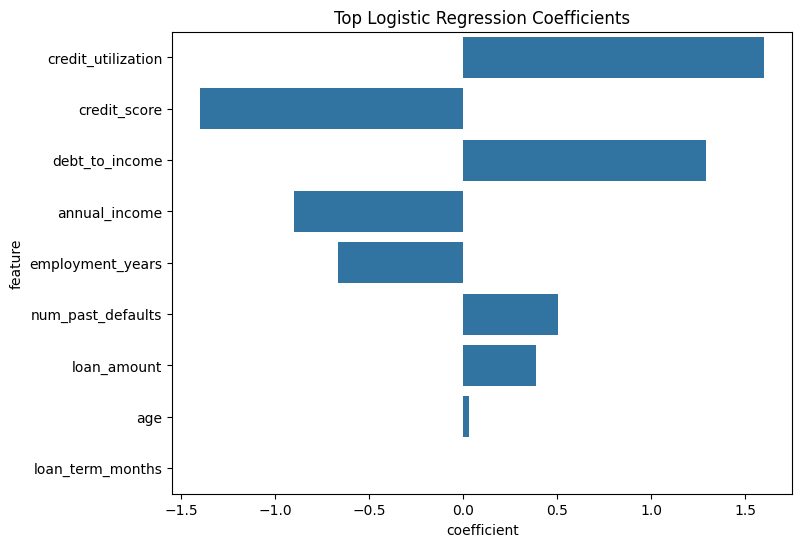

In [27]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=coef_df.sort_values("abs_coefficient", ascending=False).head(10),
    x="coefficient",
    y="feature"
)
plt.title("Top Logistic Regression Coefficients")
plt.show()


# Tree-Based Feature Importance
## Train Random Forest

In [30]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=300,
                       random_state=42)

## Extract Feature Importances

In [32]:
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)


## Visualize Importance

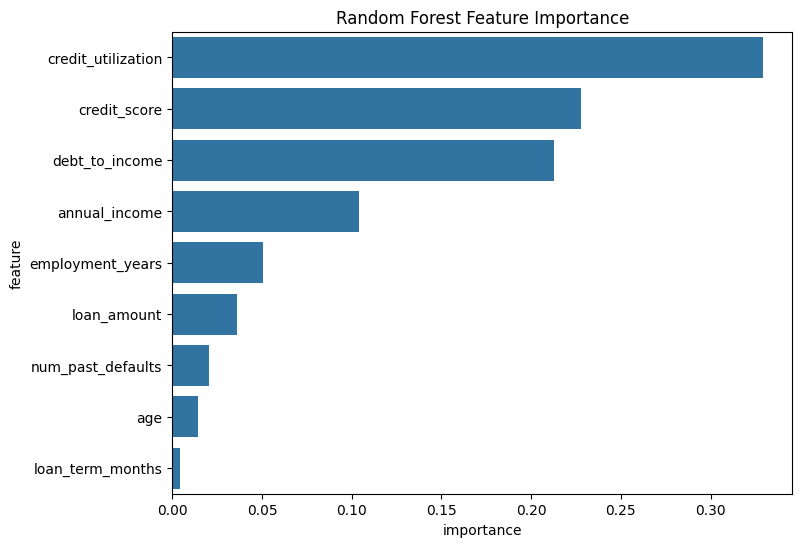

In [36]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=rf_importance.head(10),
    x="importance",
    y="feature"
)
plt.title("Random Forest Feature Importance")
plt.show()


## Comparing Importance Across Models

In [39]:
comparison = coef_df[["feature", "abs_coefficient"]].merge(
    rf_importance,
    on="feature",
    how="inner"
)

comparison.sort_values("importance", ascending=False)


,feature,abs_coefficient,importance
2,credit_utilization,1.601696,0.329026
8,credit_score,1.397074,0.227801
3,debt_to_income,1.294922,0.212808
1,annual_income,0.900986,0.104293
7,employment_years,0.666391,0.050353
4,loan_amount,0.389933,0.036163
6,num_past_defaults,0.506047,0.020629
0,age,0.032175,0.014372
5,loan_term_months,0.001657,0.004556


## Comparing Importance Across Models

In [42]:
comparison = coef_df[["feature", "abs_coefficient"]].merge(
    rf_importance,
    on="feature",
    how="inner"
)

comparison.sort_values("importance", ascending=False)


,feature,abs_coefficient,importance
2,credit_utilization,1.601696,0.329026
8,credit_score,1.397074,0.227801
3,debt_to_income,1.294922,0.212808
1,annual_income,0.900986,0.104293
7,employment_years,0.666391,0.050353
4,loan_amount,0.389933,0.036163
6,num_past_defaults,0.506047,0.020629
0,age,0.032175,0.014372
5,loan_term_months,0.001657,0.004556


📌 Disagreement is expected

📌 Indicates model-specific reliance

# What Model-Based Importance Gets Wrong

❌ Biased toward:

- High-cardinality features

- Correlated predictors

- Features with many splits

❌ Cannot detect:

- Feature interactions

- Conditional effects

- Causality

# Best Practices

- ✔ Standardize before interpreting coefficients
- ✔ Use regularization
- ✔ Compare across model families
- ✔ Pair with permutation / SHAP
- ✔ Document assumptions

# Summary Table

| Method          | Strength            | Limitation            |
| --------------- | ------------------- | --------------------- |
| Coefficients    | Directional insight | Assumes linearity     |
| Tree importance | Nonlinear effects   | Split bias            |
| Ensemble avg    | Stability           | Still model-dependent |


# Key Takeaways

- Model-based importance is global, not local

- Interpretation is model-specific

- Use as a diagnostic, not truth

- Always complement with model-agnostic methods

#  Next Notebooks
08_Interpretability_and_Explainability/

├── 01_global_interpretability/

│   ├── [02_permutation_importance.ipynb](02_permutation_importance.ipynb)

│   └── [03_partial_dependence_plots.ipynb](03_partial_dependence_plots.ipynb)